In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib


In [5]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:

df = df.drop("customerID", axis=1)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")


df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

df["Churn"] = df["Churn"].map({"Yes":1, "No":0})


In [7]:

X = df.drop("Churn", axis=1)
y = df["Churn"]


cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [8]:

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_cols),
    ("num", StandardScaler(), num_cols)
], remainder="passthrough")


In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
log_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("🔹 Logistic Regression Results")
print(classification_report(y_test, y_pred_log))


🔹 Logistic Regression Results
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [11]:

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("🔹 Random Forest Results")
print(classification_report(y_test, y_pred_rf))


🔹 Random Forest Results
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.80      0.79      1409



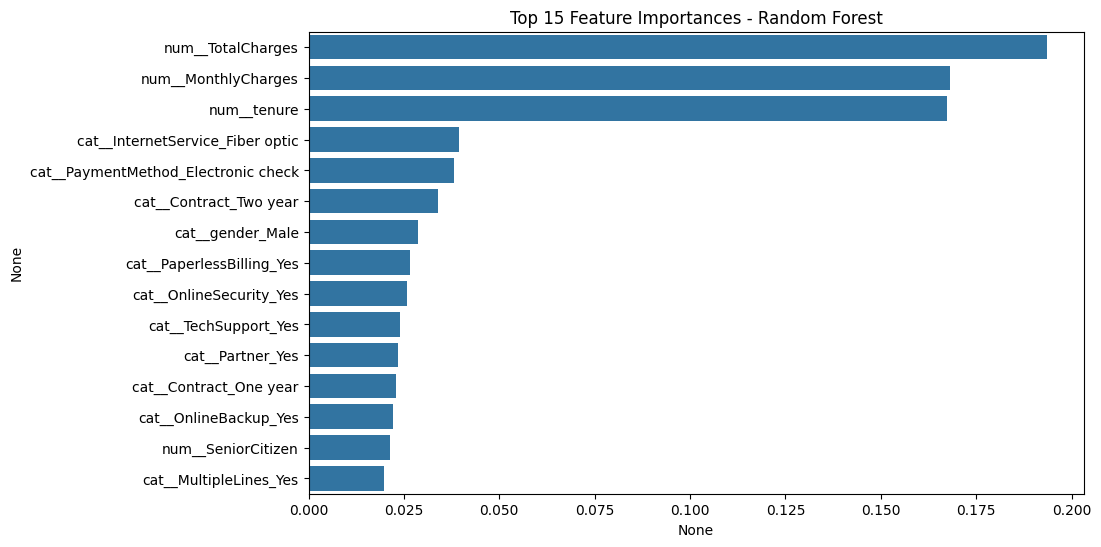

In [12]:

feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()

importances = rf_model.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()


In [13]:

joblib.dump(rf_model, "customer_churn_model.pkl")
print("✅ Model saved as customer_churn_model.pkl")


✅ Model saved as customer_churn_model.pkl
